In [7]:
from AnalyzeMot import AnalyzeMOT
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
sys.path.append('../')
import mp1_config

def strip_file_name(file_name: str) : 
    return int(file_name.split(sep='_')[-1].split('.csv')[0])

def get_amps(file_name: str) : 
    global all_files 
    number = strip_file_name(file_name)
    first_number = strip_file_name(all_files[0])
    gradient = (3.5 - 0.3*(number - first_number))
    return np.around(gradient,1)

def get_gradient(I) : 
    N = 80 # unitless, #turns for both coils
    R = 0.04 # m, radius of coils
    L = 0.08 # m, distance between coils
    mu = 4*np.pi*1e-7 #N / A^2
    geometry= R**2 * L / (R**2 + L**2/4)**(5/2)
    result = - mu * 3/2 * I * N * geometry # T / m
    dBdx = result *1e4/1e2 # G / cm
    return dBdx

def remove_trigger(time: np.array, signal:  np.array) : 
    mask = time >= 0
    return (time[mask], signal[mask])

def load_data(file: str) : 
    data = np.loadtxt(file, skiprows=2, delimiter=',')
    time, signal = remove_trigger(data[:,0], data[:,1])
    signal = signal - signal[0]

    return time, signal

def exponential(t, *ps) : 
    A, tau = ps[0], ps[1]
    return A*(1-np.exp(-t/tau))

def fit_exponential(time, signal) : 
    A0 = max(signal) - min(signal)
    tau0 = (time.max() - time.min())/3

    popt, pcov = curve_fit(exponential, xdata=time, ydata=signal, p0=[A0, tau0])
    return (popt, pcov)

def plot_fit(ax, popt, pcov, time, signal) :    
    t_fit = np.linspace(min(time), max(time), 10000)
    s_fit = exponential(t_fit, *popt)
    ax.plot(t_fit, s_fit, 'k--', label='Fit')


In [8]:
path = "./Data/Gradient/"
all_files = sorted([os.path.join(path, file) for file in os.listdir(path)])


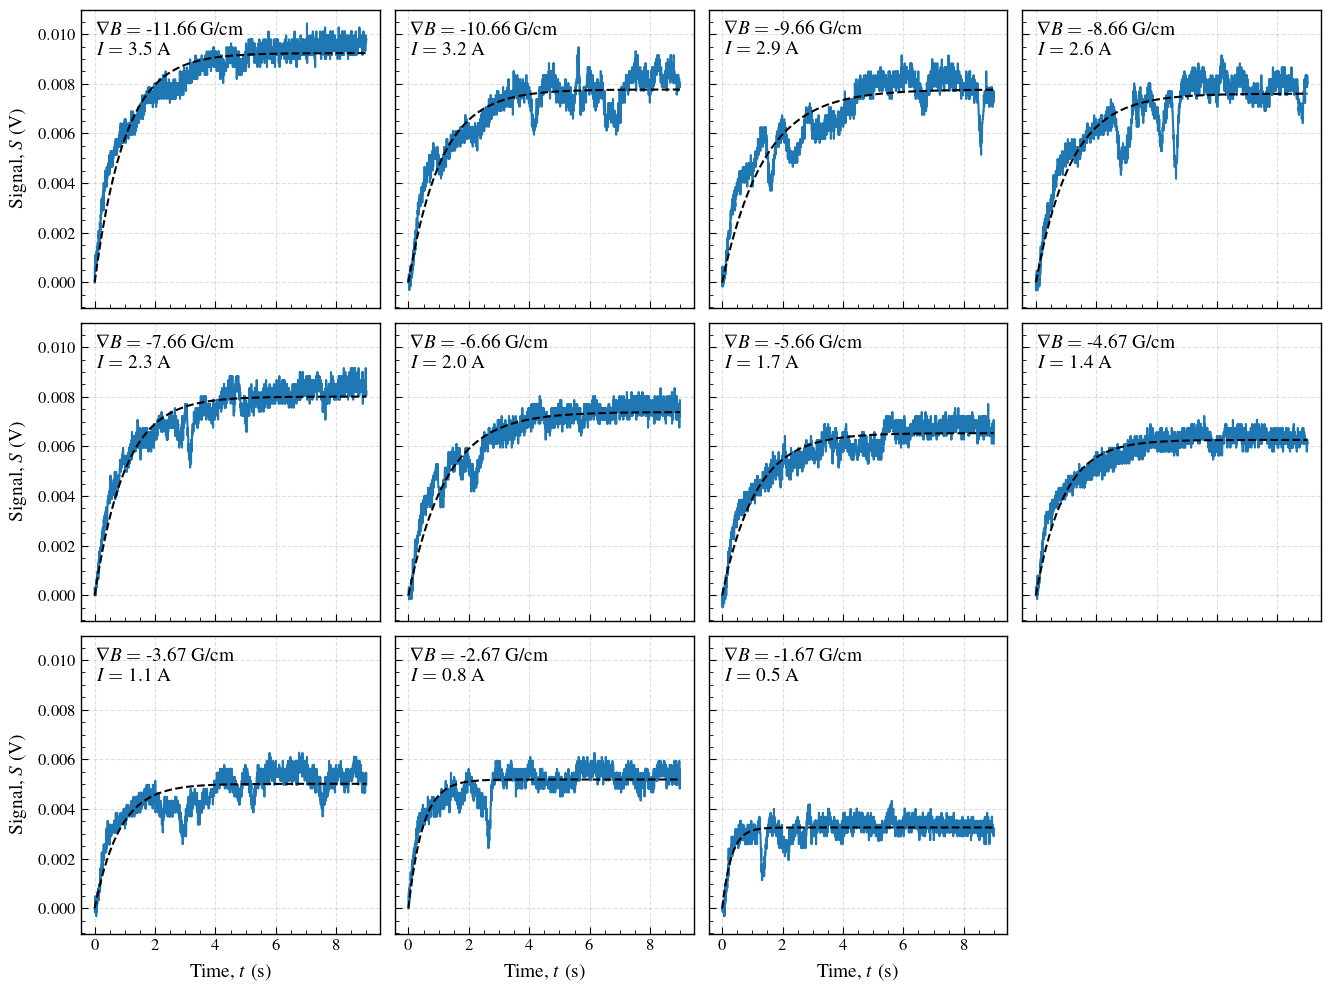

In [9]:
rows, cols = 3, 4
fig, axs = plt.subplots(rows,cols, figsize=(4*cols, 4*rows), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

norm = 1

amps = []
grad_bs = []
a_opts = []
tau_opts = []
tau_sigs = []

zips = zip(all_files, axs.flatten())
for i, (file_to_use, ax) in enumerate(zips) : 

    amp = get_amps(file_to_use)
    b_field = get_gradient(amp)

    time, signal = load_data(file_to_use)

    popt, pcov = fit_exponential(time, signal)

    ax.plot(time, signal)
    plot_fit(ax, popt, pcov, time, signal)

    ax.set_title(rf'$\nabla B =$ {b_field:.2f} G/cm'+'\n'+rf'$I =$ {amp} A', pad=-20, loc='left', transform=ax.transAxes, x=0.05, y=0.85, fontsize=14)
    ax.grid(alpha=0.25)

    amps.append(amp)
    grad_bs.append(b_field)
    a_opts.append(popt[0])
    tau_opts.append(popt[1])
    tau_sigs.append(np.sqrt(np.diag(pcov)[1]))


miss_subplots = (rows*cols) - len(all_files)
for i in range(miss_subplots) : 
    axs.flatten()[::-1][i].remove()

for ax in axs[-1] : ax.set_xlabel("Time, $t$ (s)")
for ax in axs[:,0] : ax.set_ylabel("Signal, $S$ (V)")
    
fig.savefig("./Figures/time_vs_signal_at_gradient.png", format='png', bbox_inches='tight', dpi=400)

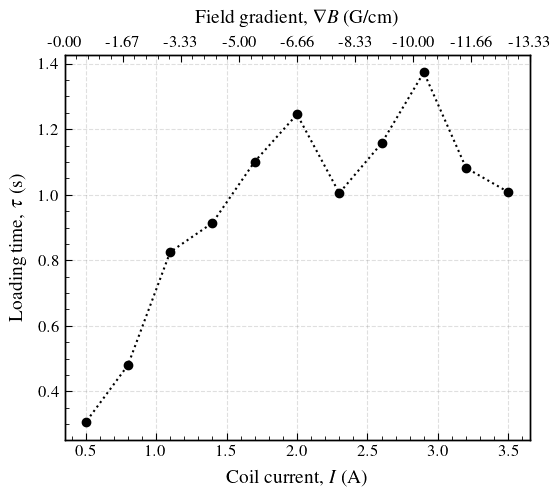

In [16]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(amps, tau_opts, 'ko:')

ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())  # Sync limits with bottom axis

amp_ticks = ax.get_xticks()
gradient_ticks = get_gradient(amp_ticks)

ax_top.set_xticks(amp_ticks)
ax_top.set_xticklabels([f'{g:.2f}' for g in gradient_ticks])

ax_top.set_xlabel(rf'Field gradient, $\nabla B$ (G/cm)')
ax.set_xlabel(rf"Coil current, $I$ (A)")
ax.set_ylabel(rf"Loading time, $\tau$ (s)")

ax.grid(alpha=0.25)

fig.savefig("./Figures/gradient_vs_loading_time.png", format='png', bbox_inches='tight', dpi=400)
